In [1]:
import numpy as np
import uproot
from matplotlib import pyplot as plt
import matplotlib as mpl
import h5py
from scipy import optimize
from src.process_data import process_data
from src.graph import graph
from src.transmission import transmission
from utils import search_asc, search_desc, xsec_to_ts, tof_to_energy, energy_to_tof, chi_sq

In [2]:
from src.process_data import process_data
from src.graph import graph
from src.transmission import transmission

In [3]:
from utils import search_asc, search_desc, xsec_to_ts, tof_to_energy, energy_to_tof, chi_sq

In [181]:
f = open("temp_data/Al.txt")
energy = []
crs = []
for line in f:
    energy.append(float(line[3:14]))
    crs.append(float(line[16:27]))
energy = np.array(energy)
crs = np.array(crs)

In [182]:
tof = energy_to_tof(energy, 181.87, 939.56542, 299792458)[::-1] * 1e9
ts = xsec_to_ts(crs * 1e-28, 2710, 0.03, 4.48e-26)[::-1]

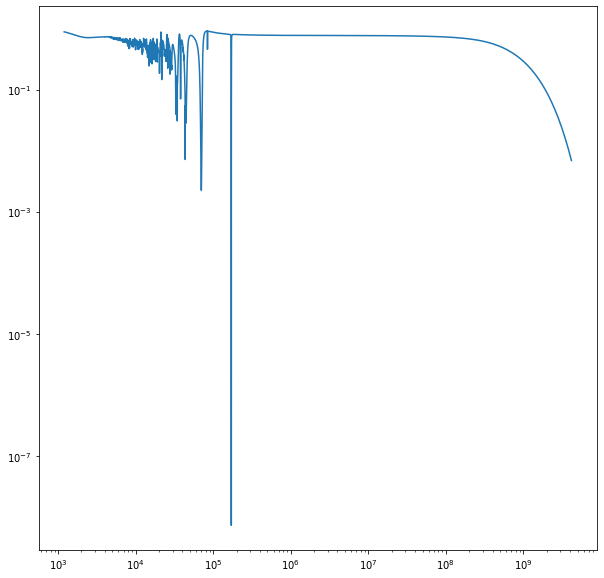

In [183]:
plt.figure(figsize=(10,10))
plt.plot(tof, ts)
plt.xscale('log')
plt.yscale('log')

In [7]:
energy_to_tof(6000 / 1e6, 182.24, 939.56542, 299792458) * 1e9

170097.5166176688

In [39]:
left = search_asc(tof, 170970)
right = search_asc(tof, 171280)

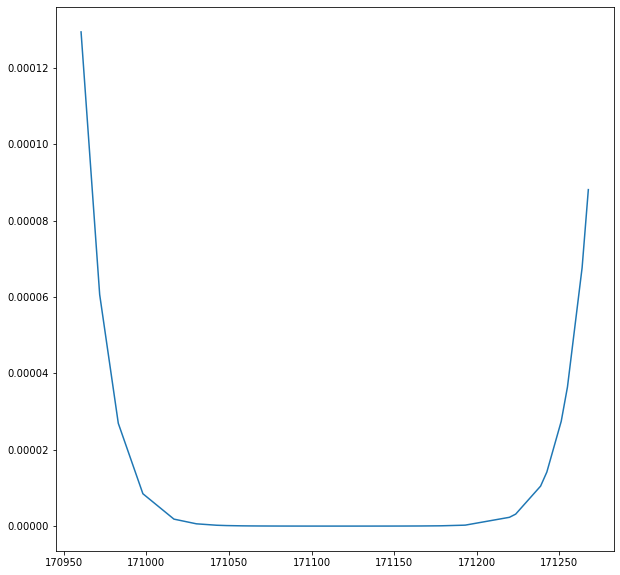

In [40]:
plt.figure(figsize=(10,10))
plt.plot(tof[left:right], ts[left:right])

In [41]:
Al3In = h5py.File("temp_data/Al3.hdf5", "r")
Al3Out = h5py.File("temp_data/empty.hdf5", "r")
amp_Al3In = Al3In['amp'][:]
en_Al3In = Al3In['energy'][:]
tof_Al3In = Al3In['tof'][:]
norm_Al3In = Al3In['norm'][0]
amp_Al3Out = Al3Out['amp'][:]
en_Al3Out = Al3Out['energy'][:]
tof_Al3Out = Al3Out['tof'][:]
norm_Al3Out = Al3Out['norm'][0]

In [46]:
tof_Al3In_select = tof_Al3In[(tof_Al3In > 170970) & (tof_Al3In < 171280) & (amp_Al3In > 4000)]

In [47]:
tof_Al3In_select

array([171124.44292412])

In [48]:
1 / norm_Al3In

6.637190034512154e-18

In [49]:
energy_to_tof(5000 / 1e6, 182.24, 939.56542, 299792458) * 1e9

186332.34491698188

In [50]:
energy_to_tof(7000 / 1e6, 182.24, 939.56542, 299792458) * 1e9

157479.82551188226

In [51]:
tof_Al3In_select = tof_Al3In[(en_Al3In > 5000) & (en_Al3In < 7000) & (amp_Al3In > 4000)]
tof_Al3Out_select = tof_Al3Out[(en_Al3Out > 5000) & (en_Al3Out < 7000) & (amp_Al3Out > 4000)]

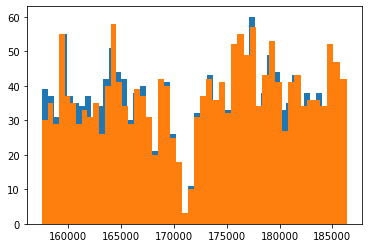

In [52]:
hist_Al3In, bins_Al3In, _, _ = graph(tof_Al3In_select, 50)

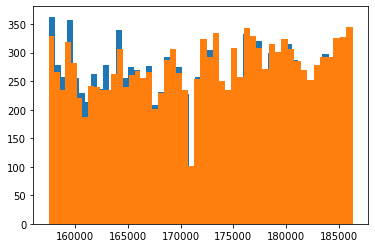

In [53]:
hist_Al3Out, bins_Al3Out, _, _ = graph(tof_Al3Out_select, 50)

In [54]:
x_tof = (bins_Al3In[1:] + bins_Al3In[:-1]) / 2

In [55]:
error_Al3In =  np.sqrt(hist_Al3In)
error_Al3In[error_Al3In == 0] = 0.7

In [56]:
tr, tr_error = transmission(hist_Al3In / norm_Al3In, error_Al3In / norm_Al3In, hist_Al3Out / norm_Al3Out, np.sqrt(hist_Al3Out) / norm_Al3Out)

<ErrorbarContainer object of 3 artists>

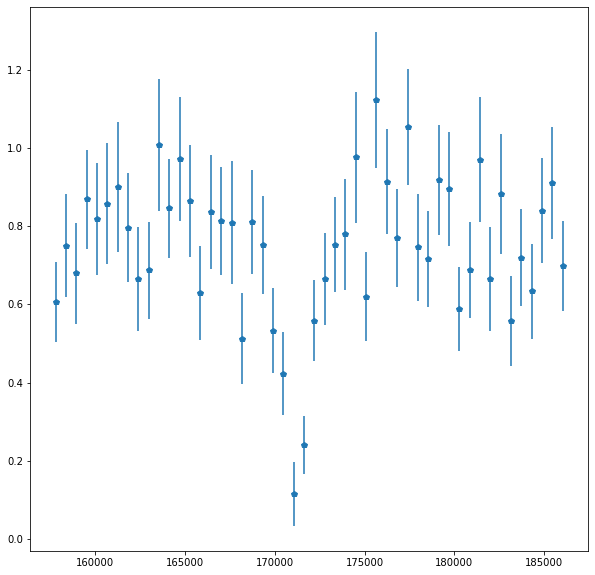

In [57]:
plt.figure(figsize=(10,10))
plt.errorbar(x_tof, tr, yerr=tr_error, fmt="p")

In [58]:
y_ts = []
for x in x_tof:
    index = search_asc(tof, x)
    y = ts[index]
    y_ts.append(y)

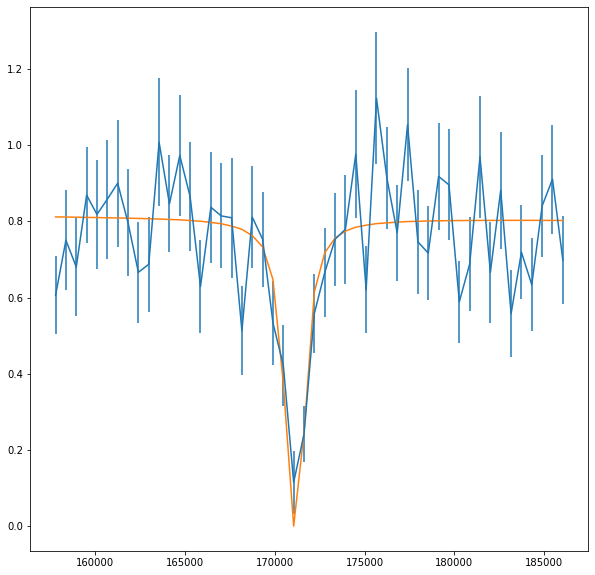

In [59]:
plt.figure(figsize=(10,10))
plt.errorbar(x_tof, tr, yerr=tr_error)
plt.plot(x_tof, y_ts)

In [79]:
def chi_sq(tr, tr_error, L, t, x_tof, crs, energy):
    ts = xsec_to_ts(np.array(crs) * 1e-28, 2710, t, 4.48e-26)[::-1]
    tof = energy_to_tof(energy, L, 939.56542, 299792458)[::-1] * 1e9
    y_ts = []
    for x in x_tof:
        y_ts.append(np.interp(x, tof, ts))
    y_ts = np.array(y_ts)
    r = y_ts - tr
    chi_sq = np.sum((r / tr_error) ** 2)
    return chi_sq

In [80]:
chi_sqs = []
Ls = np.linspace(181,184,301)

In [81]:
for L in Ls:
    chi_sqs.append(chi_sq(tr, tr_error, L, 0.01, x_tof, crs, energy))

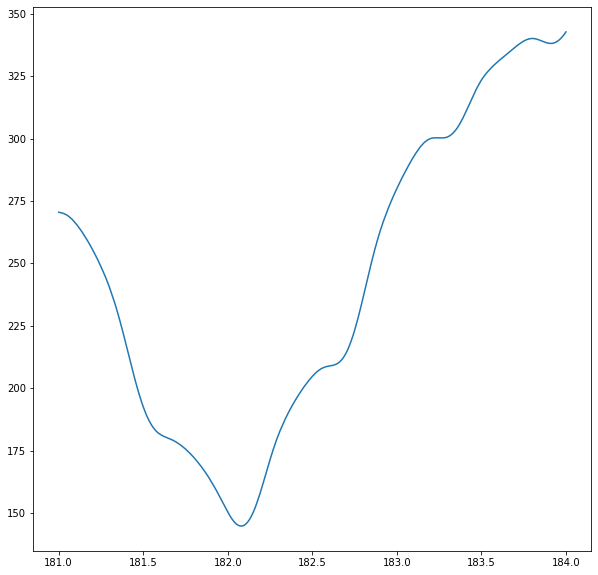

In [82]:
plt.figure(figsize=(10,10))
plt.plot(Ls, chi_sqs)
#plt.yscale('log')

In [83]:
min_idx = 0
min_chi = float('inf')
for i in range(301):
    if chi_sqs[i] < min_chi:
        min_chi = chi_sqs[i]
        min_idx = i

In [84]:
min_idx

108

In [85]:
min_chi

144.82437792938606

In [87]:
Ls[108]

182.08

In [94]:
chi_sqs2 = []
ths = np.linspace(0.025,0.040,151)

In [95]:
for th in ths:
    chi_sqs2.append(chi_sq(tr, tr_error, 182.36, th, x_tof, crs, energy))

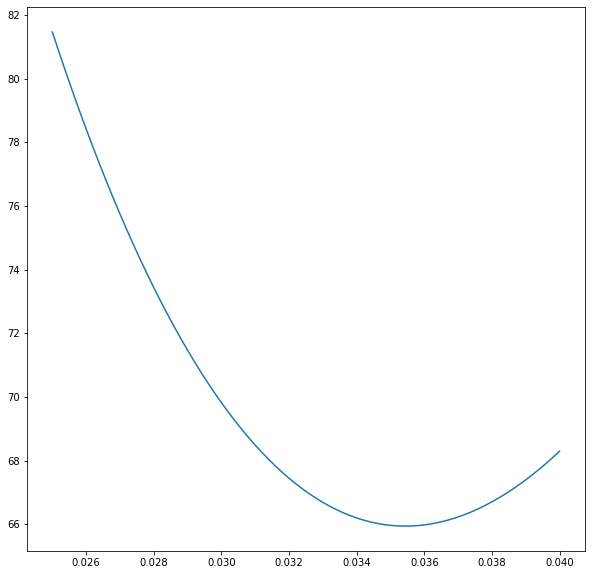

In [96]:
plt.figure(figsize=(10,10))
plt.plot(ths, chi_sqs2)

In [99]:
min_idx2 = 0
min_chi2 = float('inf')
for i in range(151):
    if chi_sqs2[i] < min_chi2:
        min_chi2 = chi_sqs2[i]
        min_idx2 = i

In [100]:
min_idx2

104

In [101]:
min_chi2

65.94534059129248

In [102]:
ths[min_idx2]

0.0354

In [107]:
def y_fit(energy, L, t):
    ts = xsec_to_ts(np.array(crs) * 1e-28, 2710, t, 4.48e-26)[::-1]
    tof = energy_to_tof(energy, L, 939.56542, 299792458)[::-1] * 1e9
    y_ts = []
    for x in x_tof:
        y_ts.append(np.interp(x, tof, ts))
    y_ts = np.array(y_ts)
    return y_ts

In [108]:
fit, sig = optimize.curve_fit(y_fit, energy, tr, sigma=tr_error, p0=[182.24, 0.01], absolute_sigma=True)

In [109]:
fit

array([1.81871877e+02, 3.42182336e-02])

In [110]:
np.sqrt(np.diag(sig))

array([0.06642027, 0.00281759])

In [111]:
tof = energy_to_tof(energy, 181.87, 939.56542, 299792458)[::-1] * 1e9
ts = xsec_to_ts(crs * 1e-28, 2710, 0.05, 4.48e-26)[::-1]

In [128]:
left = search_asc(tof, 170900)
right = search_asc(tof, 171350)

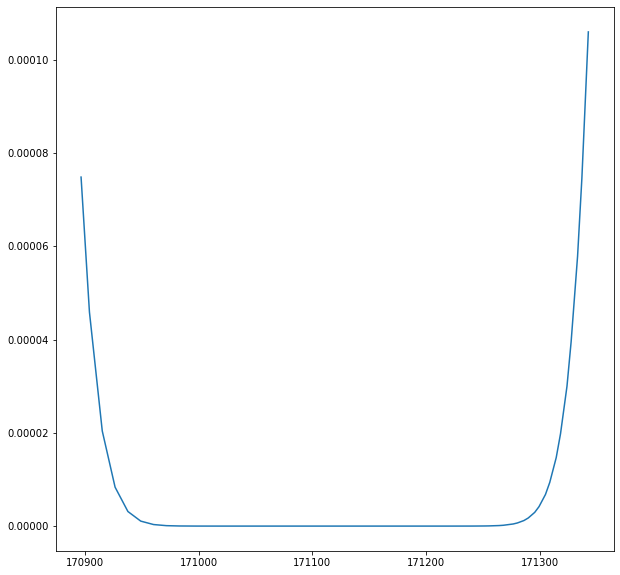

In [129]:
plt.figure(figsize=(10,10))
plt.plot(tof[left:right], ts[left:right])

In [132]:
Al5In = h5py.File("temp_data/Al5.hdf5", "r")
Al5Out = h5py.File("temp_data/empty.hdf5", "r")
amp_Al5In = Al5In['amp'][:]
en_Al5In = Al5In['energy'][:]
tof_Al5In = Al5In['tof'][:]
norm_Al5In = Al5In['norm'][0]
amp_Al5Out = Al5Out['amp'][:]
en_Al5Out = Al5Out['energy'][:]
tof_Al5Out = Al5Out['tof'][:]
norm_Al5Out = Al5Out['norm'][0]

In [133]:
tof_Al5In_select = tof_Al5In[(tof_Al5In > 170900) & (tof_Al5In < 171350) & (amp_Al5In > 4000)]

In [134]:
tof_Al5In_select

array([], dtype=float64)

In [135]:
tof_Al5In_select = tof_Al5In[(en_Al5In > 5000) & (en_Al5In < 7000) & (amp_Al5In > 4000)]
tof_Al5Out_select = tof_Al5Out[(en_Al5Out > 5000) & (en_Al5Out < 7000) & (amp_Al5Out > 4000)]

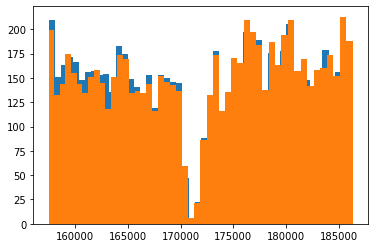

In [136]:
hist_Al5In, bins_Al5In, _, _ = graph(tof_Al5In_select, 50)

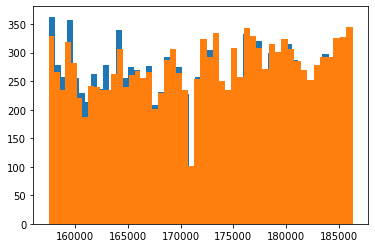

In [137]:
hist_Al5Out, bins_Al5Out, _, _ = graph(tof_Al5Out_select, 50)

In [138]:
x_tof = (bins_Al5In[1:] + bins_Al5In[:-1]) / 2

In [139]:
error_Al5In =  np.sqrt(hist_Al5In)
error_Al5In[error_Al5In == 0] = 0.7

In [140]:
tr, tr_error = transmission(hist_Al5In / norm_Al5In, error_Al5In / norm_Al5In, hist_Al5Out / norm_Al5Out, np.sqrt(hist_Al5Out) / norm_Al5Out)

<ErrorbarContainer object of 3 artists>

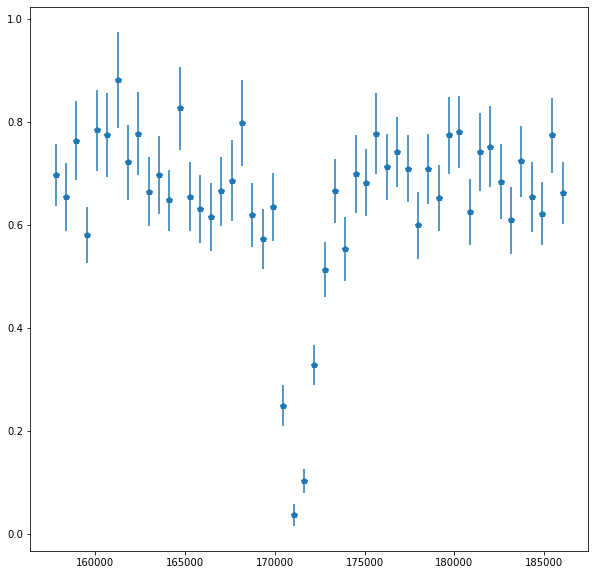

In [141]:
plt.figure(figsize=(10,10))
plt.errorbar(x_tof, tr, yerr=tr_error, fmt="p")

In [142]:
y_ts = []
for x in x_tof:
    index = search_asc(tof, x)
    y = ts[index]
    y_ts.append(y)

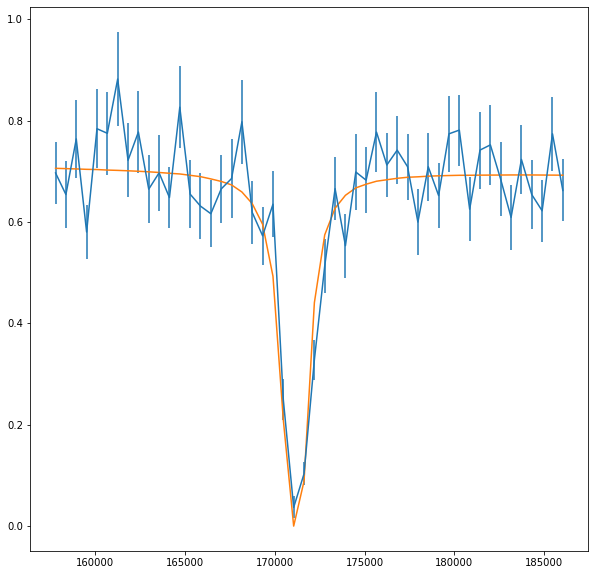

In [143]:
plt.figure(figsize=(10,10))
plt.errorbar(x_tof, tr, yerr=tr_error)
plt.plot(x_tof, y_ts)

In [144]:
fit, sig = optimize.curve_fit(y_fit, energy, tr, sigma=tr_error, p0=[182.24, 0.01], absolute_sigma=True)

In [145]:
fit

array([1.81913845e+02, 5.01809437e-02])

In [146]:
np.sqrt(np.diag(sig))

array([0.03150442, 0.0016721 ])

In [150]:
tof = energy_to_tof(energy, 181.87, 939.56542, 299792458)[::-1] * 1e9
ts = xsec_to_ts(crs * 1e-28, 2710, 0.08, 4.48e-26)[::-1]

In [163]:
left = search_asc(tof, 170820)
right = search_asc(tof, 171430)

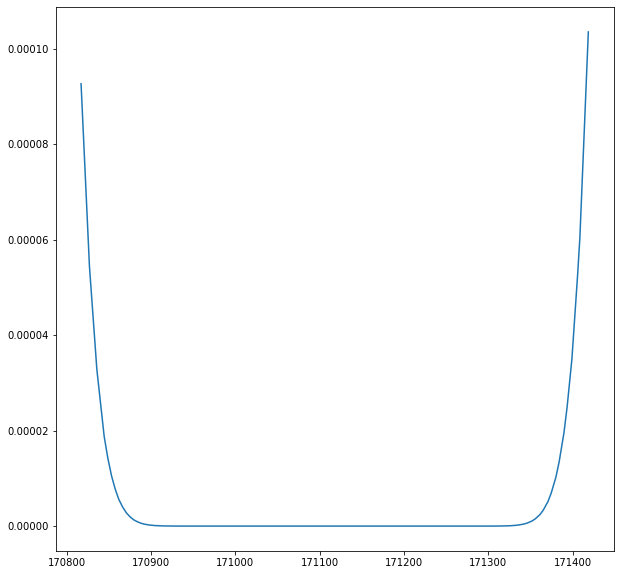

In [164]:
plt.figure(figsize=(10,10))
plt.plot(tof[left:right], ts[left:right])

In [165]:
Al8In = h5py.File("temp_data/Al8.hdf5", "r")
Al8Out = h5py.File("temp_data/empty.hdf5", "r")
amp_Al8In = Al8In['amp'][:]
en_Al8In = Al8In['energy'][:]
tof_Al8In = Al8In['tof'][:]
norm_Al8In = Al8In['norm'][0]
amp_Al8Out = Al8Out['amp'][:]
en_Al8Out = Al8Out['energy'][:]
tof_Al8Out = Al8Out['tof'][:]
norm_Al8Out = Al8Out['norm'][0]

In [166]:
tof_Al8In_select = tof_Al8In[(tof_Al8In > 170820) & (tof_Al8In < 171430) & (amp_Al8In > 4000)]

In [167]:
tof_Al8In_select

array([171312.87442207])

In [168]:
1 / norm_Al8In

6.415474963713075e-18

In [169]:
tof_Al8In_select = tof_Al8In[(en_Al8In > 5000) & (en_Al8In < 7000) & (amp_Al8In > 4000)]
tof_Al8Out_select = tof_Al8Out[(en_Al8Out > 5000) & (en_Al8Out < 7000) & (amp_Al8Out > 4000)]

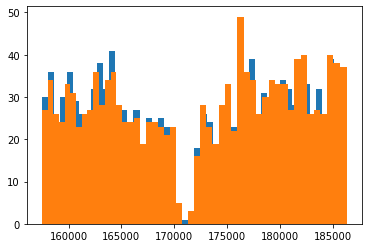

In [170]:
hist_Al8In, bins_Al8In, _, _ = graph(tof_Al8In_select, 50)

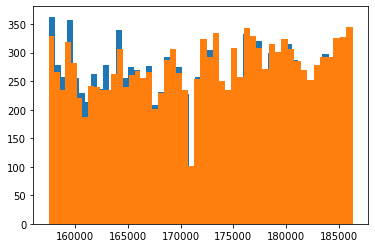

In [171]:
hist_Al8Out, bins_Al8Out, _, _ = graph(tof_Al8Out_select, 50)

In [172]:
x_tof = (bins_Al8In[1:] + bins_Al8In[:-1]) / 2

In [173]:
error_Al8In =  np.sqrt(hist_Al8In)
error_Al8In[error_Al8In == 0] = 0.7

In [174]:
tr, tr_error = transmission(hist_Al8In / norm_Al8In, error_Al8In / norm_Al8In, hist_Al8Out / norm_Al8Out, np.sqrt(hist_Al8Out) / norm_Al8Out)

<ErrorbarContainer object of 3 artists>

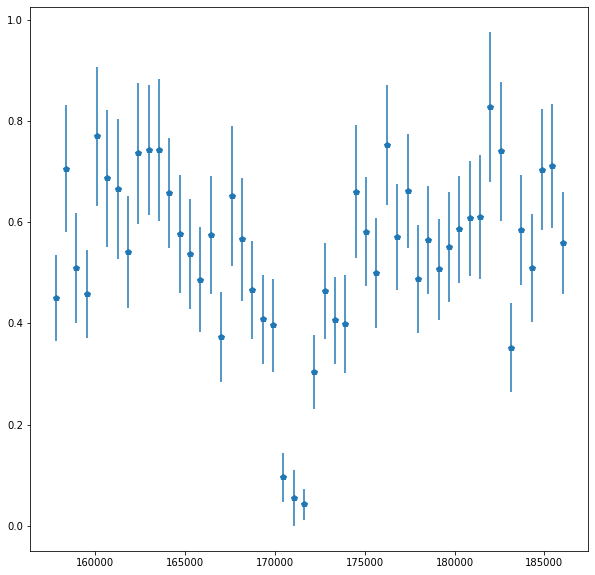

In [175]:
plt.figure(figsize=(10,10))
plt.errorbar(x_tof, tr, yerr=tr_error, fmt="p")

In [176]:
y_ts = []
for x in x_tof:
    y_ts.append(np.interp(x, tof, ts))

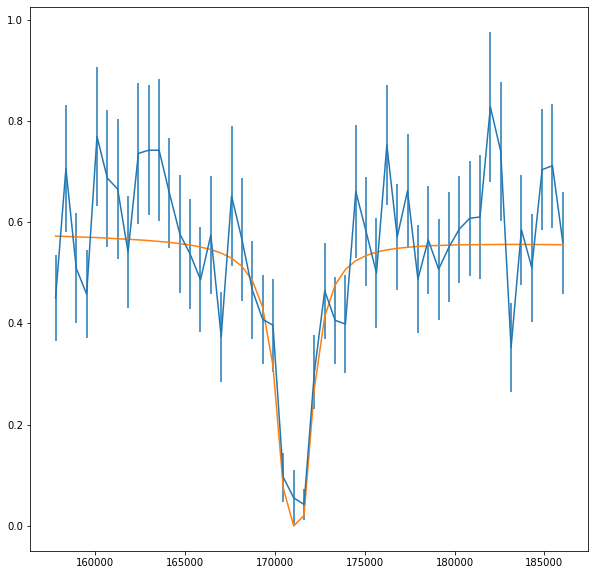

In [177]:
plt.figure(figsize=(10,10))
plt.errorbar(x_tof, tr, yerr=tr_error)
plt.plot(x_tof, y_ts)

In [178]:
fit, sig = optimize.curve_fit(y_fit, energy, tr, sigma=tr_error, p0=[182.24, 0.01], absolute_sigma=True)

In [179]:
fit

array([1.81857741e+02, 7.60429009e-02])

In [180]:
np.sqrt(np.diag(sig))

array([0.06702562, 0.00352342])